In [1]:
import os
import numpy as np
import pandas as pd

from omegaconf import OmegaConf

import tensorflow as tf

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay

from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

from xgboost import XGBClassifier

Dense = tf.keras.layers.Dense
Input = tf.keras.layers.Input
Sequential = tf.keras.Sequential
MeanSquaredError = tf.keras.losses.MeanSquaredError
BinaryCrossentropy = tf.keras.losses.BinaryCrossentropy
Sigmoid = tf.keras.activations.sigmoid

file_path = os.getcwd()

conf = OmegaConf.load(os.path.join(file_path, "..", "src", "config.yml"))

data_path = os.path.join(file_path, "..", "data", "UCI_Credit_Card.csv")

df = pd.read_csv(data_path)

lambdas = [0, 1e-5, 1e-4, 5e-4, 1e-3]

c:\Users\samue\Downloads\projetos\py\mlcreditcardclients\.env\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [2]:
def create_percent_paid_features(df):
    for i in range(1, 7):
        df[f"PCT_PAID_{i}"] = np.where(
            df[f"BILL_AMT{i}"] > 0,
            df[f"PAY_AMT{i}"] / df[f"BILL_AMT{i}"],
            0
        )

    df["PCT_PAID_MEAN"] = df[[f"PCT_PAID_{i}" for i in range(1, 7)]].mean(axis=1)
    return df


def create_credit_utilization(df):
    bill_cols = [f"BILL_AMT{i}" for i in range(1, 7)]
    df["BILL_MEAN"] = df[bill_cols].mean(axis=1)

    df["CREDIT_UTILIZATION"] = np.where(
        df["LIMIT_BAL"] > 0,
        df["BILL_MEAN"] / df["LIMIT_BAL"],
        0
    )
    return df


def create_pay_delay_features(df):
    pay_cols = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
    df["PAY_DELAY_MEAN"] = df[pay_cols].mean(axis=1)
    df["PAY_DELAY_MAX"] = df[pay_cols].max(axis=1)
    return df


def feature_engineering(df):
    df = df.copy()
    df = create_percent_paid_features(df)
    df = create_credit_utilization(df)
    df = create_pay_delay_features(df)
    return df


In [3]:
def plot_confusion_matrix(y_true, y_proba, threshold):
    y_pred = (y_proba >= threshold).astype(int)

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=["No Default", "Default"])

    disp.plot(cmap="Blues", values_format="d")
    plt.title(f"Confusion Matrix (threshold={threshold:.3f})")
    plt.show()

    tn, fp, fn, tp = cm.ravel()

    print("📊 Impacto de negócio:")
    print(f"TP (inadimplentes detectados): {tp}")
    print(f"FN (inadimplentes aprovados ❌): {fn}")
    print(f"FP (bons clientes recusados): {fp}")
    print(f"TN (bons clientes aprovados): {tn}")

In [4]:
def prepare_data(df, params):

    df = feature_engineering(df)
    # ===============================
    # TARGET
    # ===============================
    y = df['default.payment.next.month']


    # ===============================
    # FEATURES
    # ===============================
    X = df[
        [
            'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE',
            'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
            'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3',
            'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
            'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
            'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
            'PCT_PAID_MEAN',
            'CREDIT_UTILIZATION',
            'PAY_DELAY_MEAN',
            'PAY_DELAY_MAX'
        ]
    ]
    
    # ===============================
    # DEFINIÇÃO DOS TIPOS
    # ===============================
    binary_features = ['SEX']
    categorical_features = ['EDUCATION', 'MARRIAGE']
    numerical_features = [col for col in X.columns if col not in binary_features + categorical_features]
    # numerical_features = [
    #     'LIMIT_BAL',
    #     'AGE',
    #     'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
    #     'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3',
    #     'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
    #     'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
    #     'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'
    # ]
    
    # ===============================
    # PREPROCESSAMENTO
    # ===============================
    preprocessor = ColumnTransformer(
        transformers=[
            ('bin', MinMaxScaler(), binary_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
            ('num', MinMaxScaler(), numerical_features)
        ]
    )
    
    # ===============================
    # SPLIT
    # ===============================
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=params["test_size"],
        random_state=params["random_state"],
        stratify=y
    )
    
    # ===============================
    # TRANSFORMAR DADOS
    # ===============================
    X_train = preprocessor.fit_transform(X_train)
    X_test = preprocessor.transform(X_test)

    return X_train, X_test, y_train, y_test

In [5]:
def cross_validate_lambda(X, y, lambdas, params):

    skf = StratifiedKFold(
        n_splits=params["cv_folds"],
        shuffle=True,
        random_state=params["random_state"]
    )

    best_lambda = None
    best_auc = -np.inf

    for lambda_ in lambdas:
        aucs = []

        for train_idx, val_idx in skf.split(X, y):

            X_tr, X_val = X[train_idx], X[val_idx]
            y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

            model = Sequential([
                Dense(64, activation='relu',
                      kernel_regularizer=tf.keras.regularizers.l2(lambda_)),
                Dense(32, activation='relu',
                      kernel_regularizer=tf.keras.regularizers.l2(lambda_)),
                Dense(1, activation='linear')
            ])

            model.compile(
                optimizer=tf.keras.optimizers.Adam(
                    learning_rate=params["learning_rate"]
                ),
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True)
            )

            model.fit(
                X_tr,
                y_tr,
                epochs=params["epochs_cross"],
                verbose=params["verbose"]
            )

            logits = model(X_val)
            y_pred_proba = tf.nn.sigmoid(logits).numpy().ravel()

            auc = roc_auc_score(y_val, y_pred_proba)
            aucs.append(auc)

        mean_auc = np.mean(aucs)
        std_auc = np.std(aucs)

        print(f"[CV] λ={lambda_:.5f} | AUC={mean_auc:.4f} ± {std_auc:.4f}")

        if mean_auc > best_auc:
            best_auc = mean_auc
            best_lambda = lambda_


    return best_lambda

In [6]:
def train_final_model(X_train, X_test, y_train, y_test, best_lambda, params):

    model = Sequential([
        Dense(64, activation='relu',
              kernel_regularizer=tf.keras.regularizers.l2(best_lambda)),
        Dense(32, activation='relu',
              kernel_regularizer=tf.keras.regularizers.l2(best_lambda)),
        Dense(1, activation='linear')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=params["learning_rate"]
        ),
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=True)
    )

    model.fit(
        X_train,
        y_train,
        epochs=params["epochs"],
        verbose=params["verbose"]
    )

    logits = model(X_test)
    y_proba = tf.nn.sigmoid(logits).numpy().ravel()

    auc = roc_auc_score(y_test, y_proba)
    print(f"📊 Neural Network ROC-AUC: {auc:.4f}")

    return y_proba, auc


In [7]:
def find_best_threshold(y_true, y_proba):
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_proba)

    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-9)
    best_idx = np.argmax(f1_scores)

    best_threshold = thresholds[best_idx]
    best_f1 = f1_scores[best_idx]

    print(f"🎯 Melhor threshold: {best_threshold:.3f}")
    print(f"📈 Melhor F1-score: {best_f1:.4f}")

    return best_threshold

In [8]:
def plot_roc_curves(y_test, preds_dict):
    plt.figure(figsize=(8, 6))

    for name, y_proba in preds_dict.items():
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        auc = roc_auc_score(y_test, y_proba)
        plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve Comparison")
    plt.legend()
    plt.grid(True)
    plt.show()

[CV] λ=0.00000 | AUC=0.7661 ± 0.0058
[CV] λ=0.00001 | AUC=0.7685 ± 0.0081
[CV] λ=0.00010 | AUC=0.7642 ± 0.0063
[CV] λ=0.00050 | AUC=0.7572 ± 0.0076
[CV] λ=0.00100 | AUC=0.7523 ± 0.0037
🏆 Melhor lambda escolhido via CV: 1.0e-05
📊 Neural Network ROC-AUC: 0.7724

🔎 Threshold ótimo (Neural Network)
🎯 Melhor threshold: 0.311
📈 Melhor F1-score: 0.5448


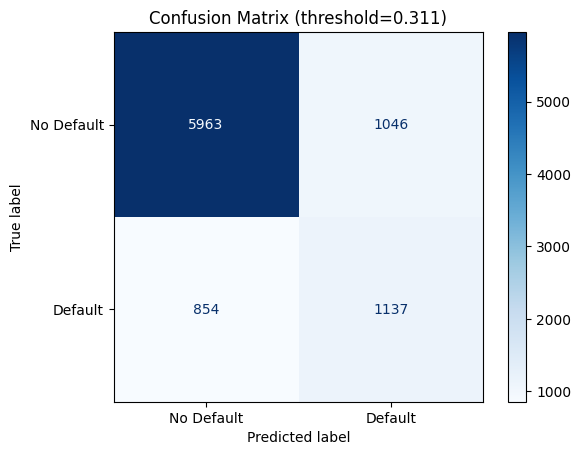

📊 Impacto de negócio:
TP (inadimplentes detectados): 1137
FN (inadimplentes aprovados ❌): 854
FP (bons clientes recusados): 1046
TN (bons clientes aprovados): 5963


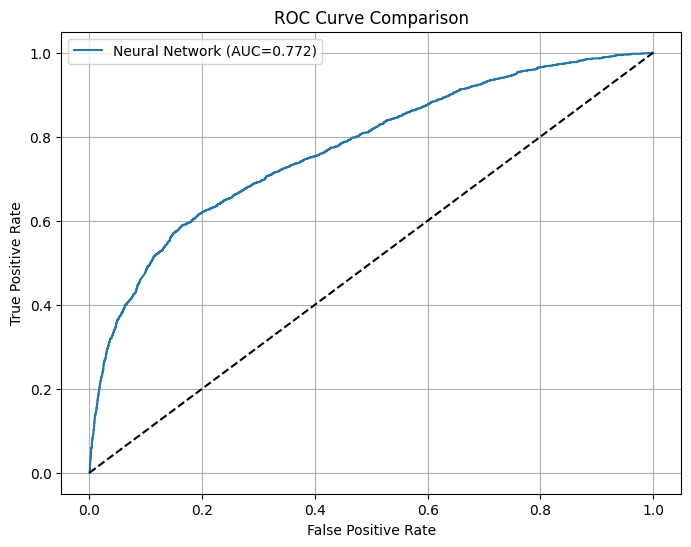

In [9]:
def main():
     
    # Preparação dos dados
    X_train, X_test, y_train, y_test = prepare_data(df, conf["parameters"])

    best_lambda = cross_validate_lambda(X_train, y_train, lambdas, conf["parameters"])

    print(f"🏆 Melhor lambda escolhido via CV: {best_lambda:.1e}")

    nn_proba, _ = train_final_model(
        X_train, X_test, y_train, y_test, best_lambda, conf["parameters"]
    )

    print("\n🔎 Threshold ótimo (Neural Network)")
    best_threshold = find_best_threshold(y_test, nn_proba)

    plot_confusion_matrix(y_test, nn_proba, best_threshold)

    plot_roc_curves(
        y_test,
        {"Neural Network": nn_proba}
    )
    
if __name__ == "__main__":
    main()
